<a href="https://colab.research.google.com/github/Mitmischer/sepsis-prediction/blob/main/preprocessing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [1]:
from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
%pip install zstandard
import zstandard
drive.mount('/content/drive')
%mkdir -p "/tmp/sepsis"
%cp "/content/drive/My Drive/sepsis/training.tar.zst" "/tmp/sepsis"
%cp /content/drive/My\ Drive/sepsis/training_setA*.csv "/tmp/sepsis"
%cd "/tmp/sepsis"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/tmp/sepsis


**Read data file**

In [15]:
dctx = zstandard.ZstdDecompressor()
with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
    dctx.copy_stream(ifh, ofh)

my_tar = tarfile.open('training.tar')
my_tar.extractall('/tmp/sepsis') # specify which folder to extract to
my_tar.close()
%cd "training/training_setA"

/tmp/sepsis/training/training_setA


In [29]:
# load all data sets (roughly 20000 for set A)
wd = Path(".")
full_df_from_disk = list(pd.read_csv(f, sep = "|") for f in wd.glob("p0*.psv"))
full_df = pd.concat(full_df_from_disk)

#

KeyboardInterrupt: ignored

## Preprocess Data File

In [71]:
full_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,NaN,134.0,72.67,NaN,20.0,NaN,NaN,...,NaN,266.0,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,NaN,NaN,NaN,143.0,80.33,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,NaN,16.0,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,NaN,155.0,98.33,NaN,20.0,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,5,0,0


In [17]:
full_df.columns

Index(['time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')

Reset index, creating time variable

In [9]:
def add_patient_id_and_idx(df):
  # Reset index, creating time variable
  df = df.reset_index(names=["time"])
  # Add patient id variable
  groups_by_patient = df['time'].diff().lt(0)
  groups_by_sepsis_label = df['SepsisLabel'].diff().abs().gt(0)
  result = pd.concat([groups_by_patient, groups_by_sepsis_label], axis=1)
  groups = result.any(axis=1)
  df['patient_id'] = groups_by_patient.cumsum()
  df['measurement_id'] = groups.cumsum()

  return df

In [69]:
full_df = add_patient_id_and_idx(full_df)

ValueError: ignored

In [ ]:
display(full_df)

Optional: save as csv

In [ ]:
# full_df.to_csv("/tmp/sepsis/training_setA.csv", index=False)

## Exploratory Data Analysis

### Single and Subsample Analysis

Single case

In [18]:
first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

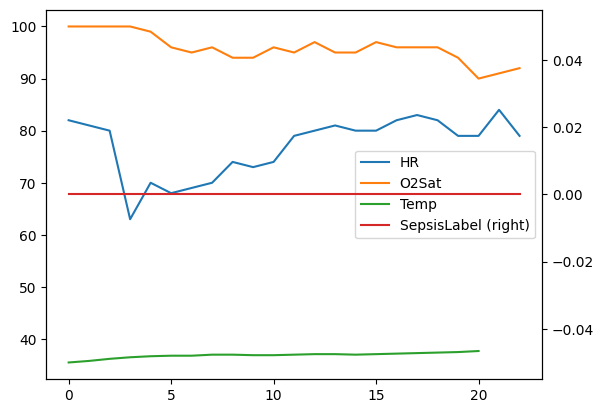

In [19]:
ax = first_patient_df[["HR", "O2Sat", "Temp"]].plot()
first_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

In [72]:
first_patient_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

<Axes: >

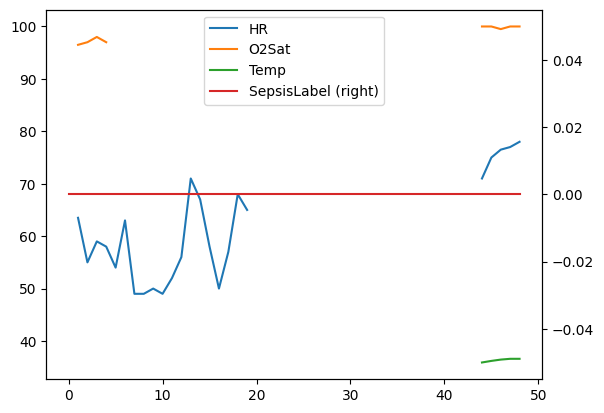

In [21]:
second_patient_df = pd.read_csv("p000111.psv", sep="|")
ax = second_patient_df[["HR", "O2Sat", "Temp"]].plot()
second_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

Subsample (first n samples)

In [22]:
# load the first 10 data sets
wd = Path(".")
sample_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
sample_df = pd.concat(sample_df)

<Axes: >

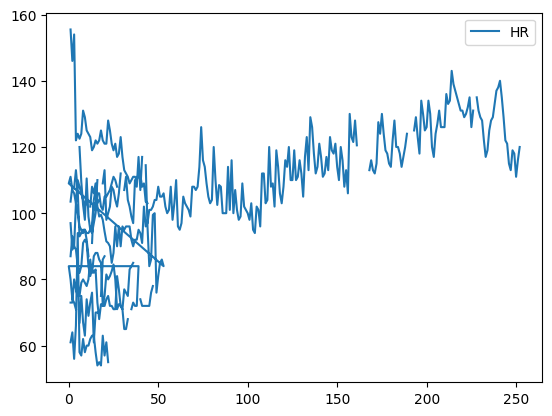

In [23]:
sample_df[["HR"]].plot()

39.6956956956957 mean total hours time in the ICU


Text(0.5, 0, 'ICULOS (days)')

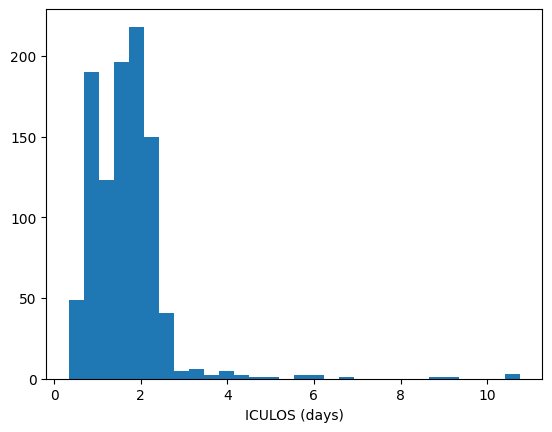

In [24]:
# load the first 1000 data sets
# what is the mean total time in the ICU (ICULOS)?
# ICULOS = intensive care unit length of stay
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
ICULOS_times = np.array([])
for df in big_df:
  ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
plt.hist(ICULOS_times/24, bins=30)
plt.xlabel('ICULOS (days)')

### Full Sample Analysis

Number of patiens in total and patients with sepsis

In [25]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")



Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

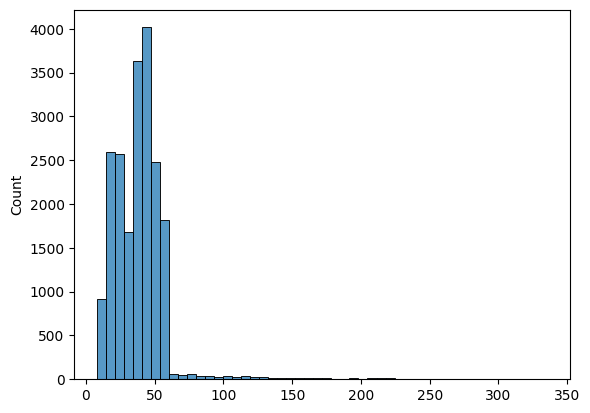

In [26]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

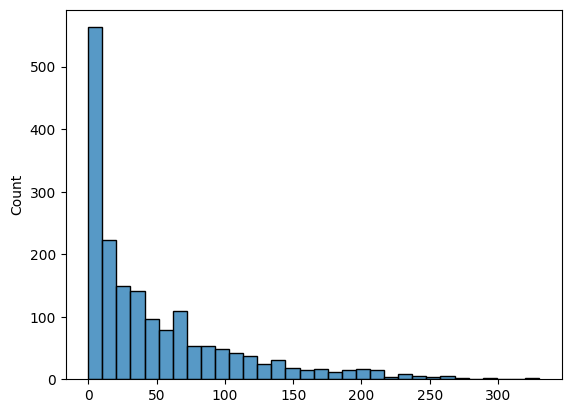

In [27]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])

sns.histplot(sepsis_time, kde=False);


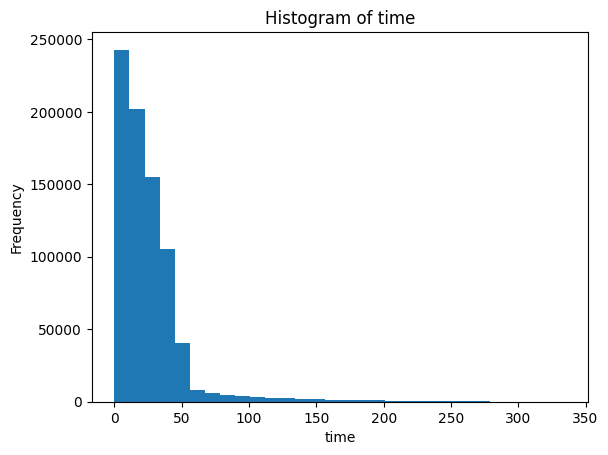

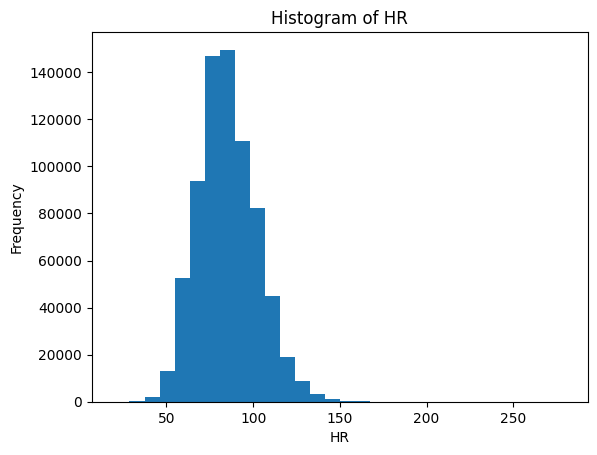

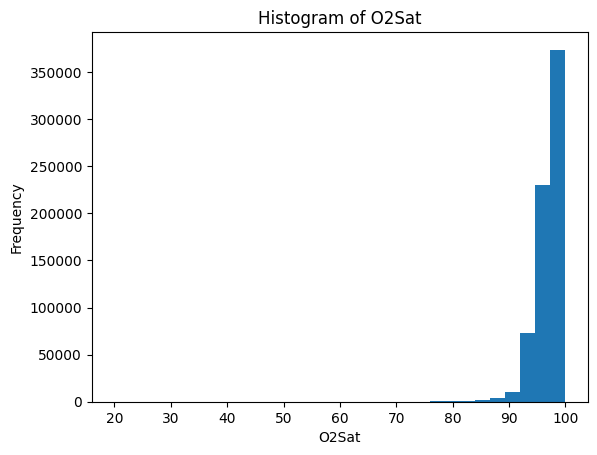

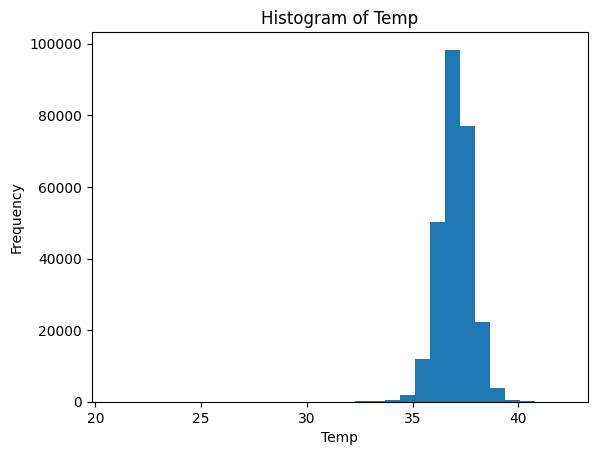

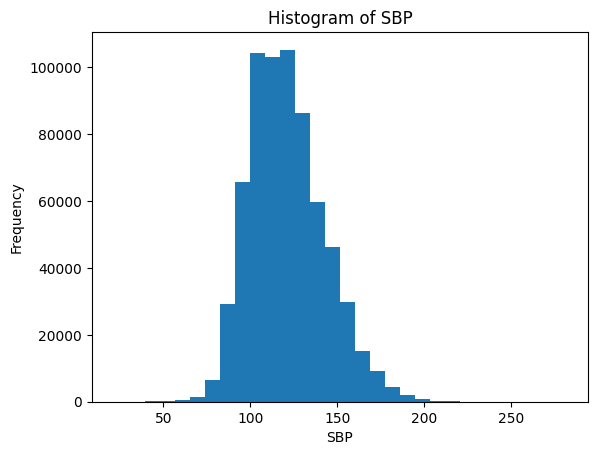

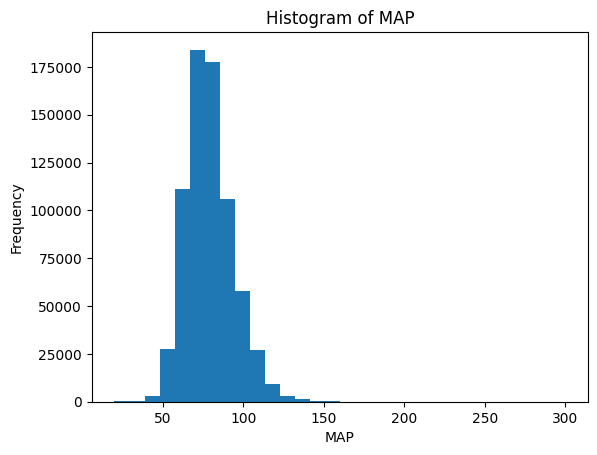

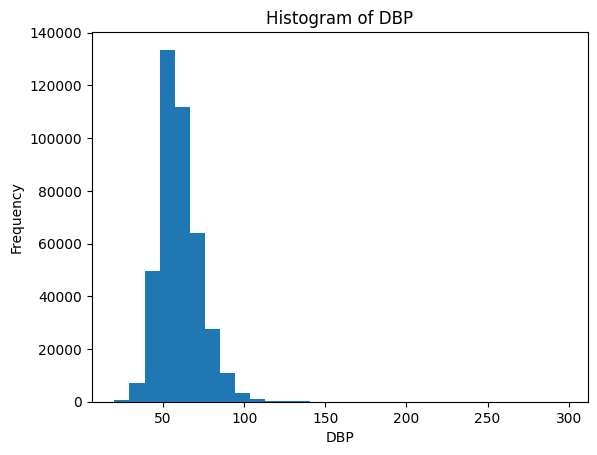

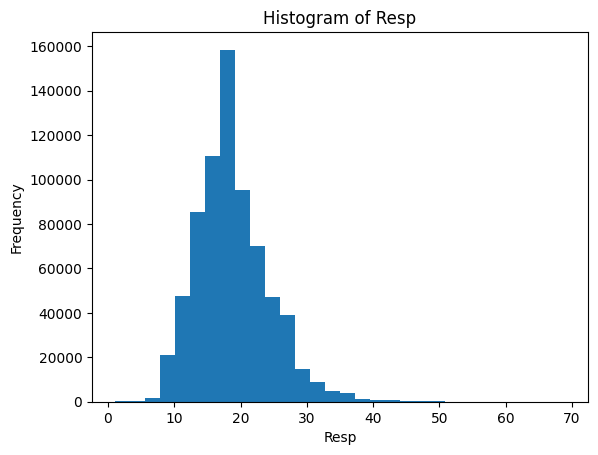

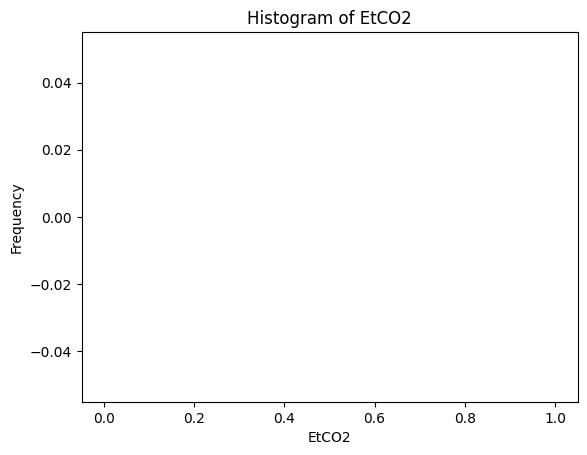

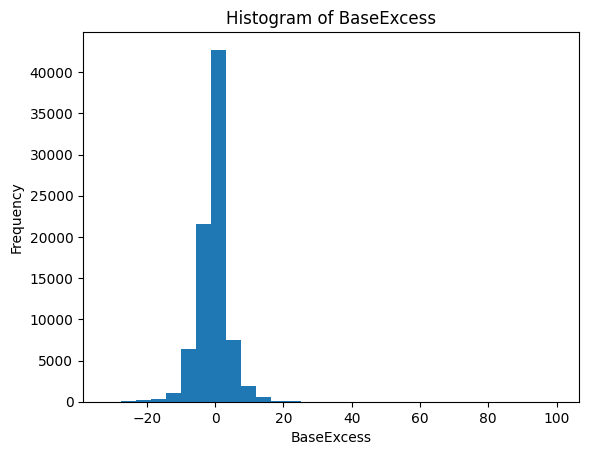

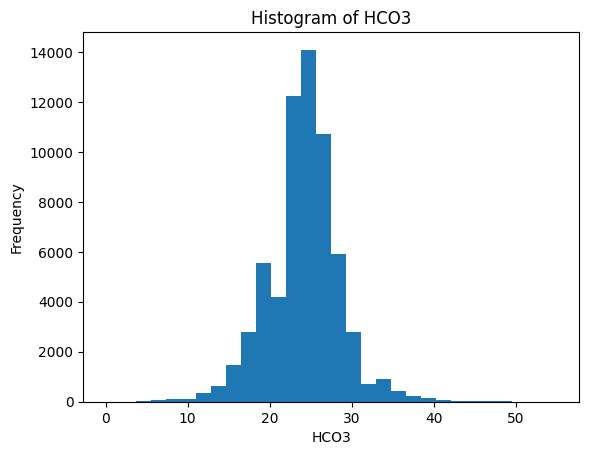

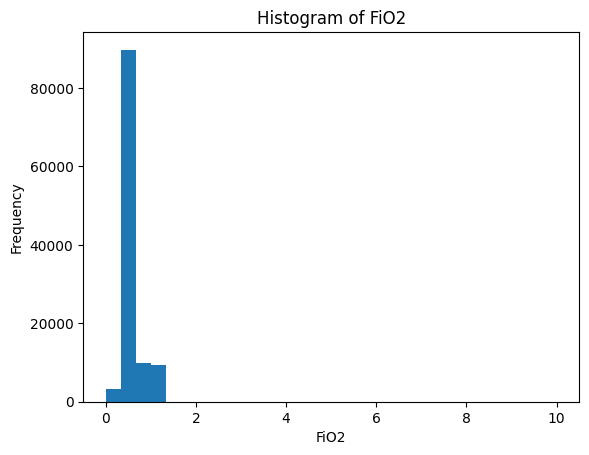

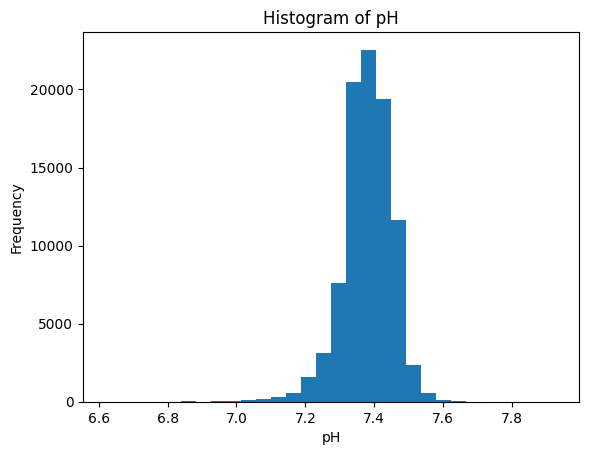

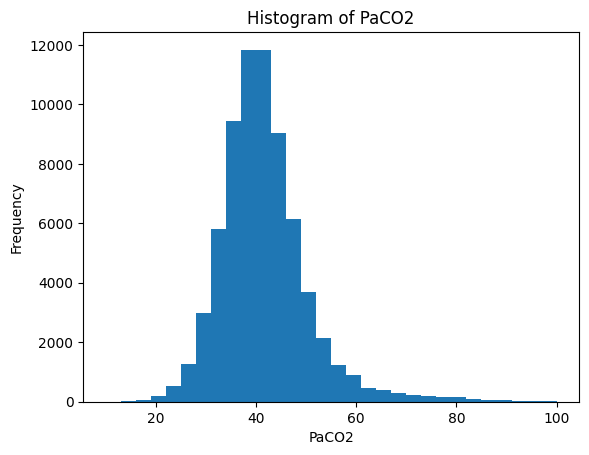

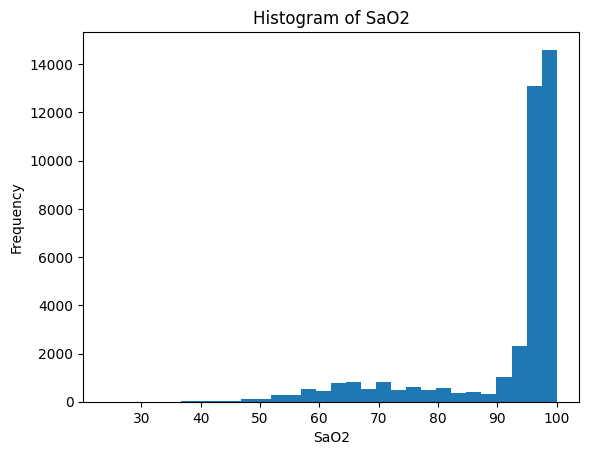

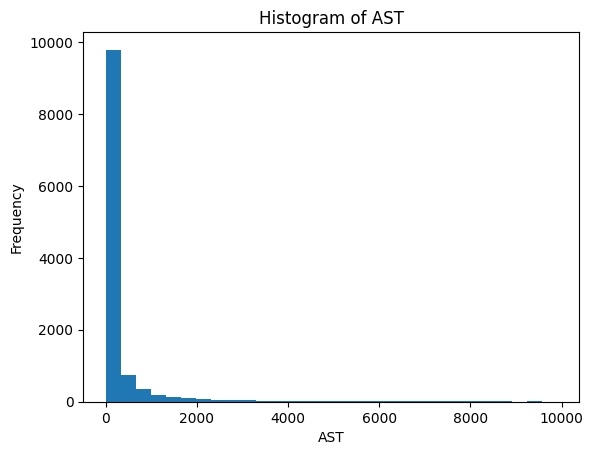

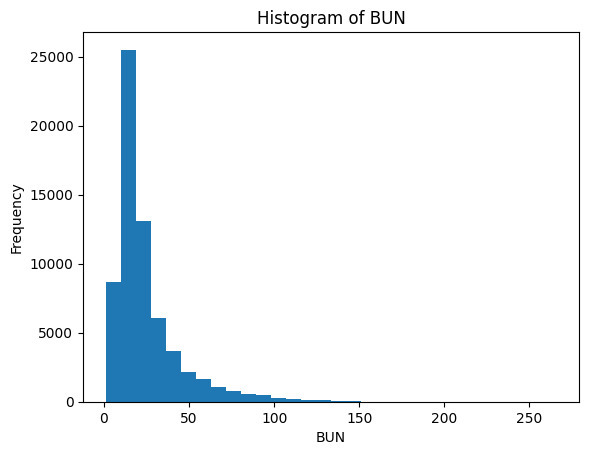

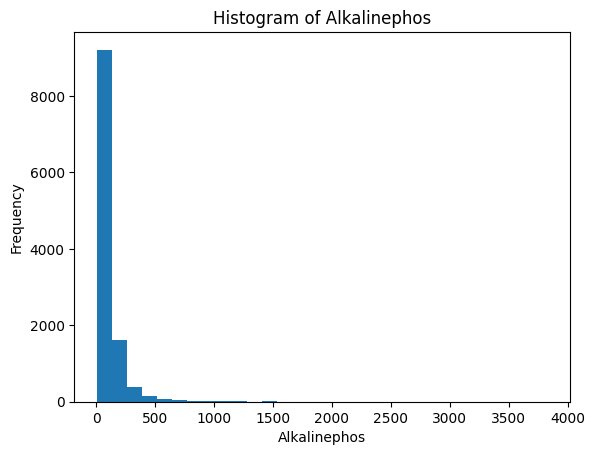

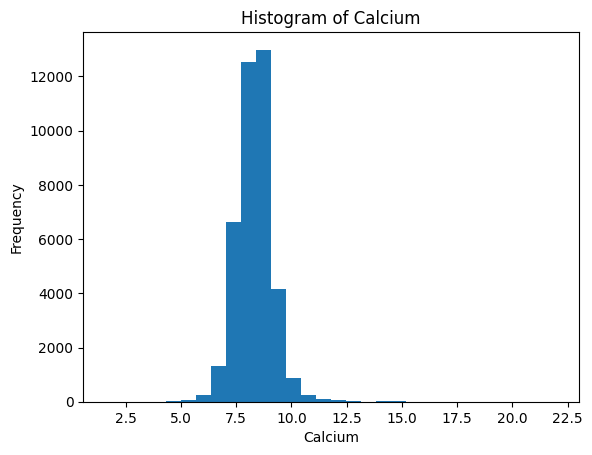

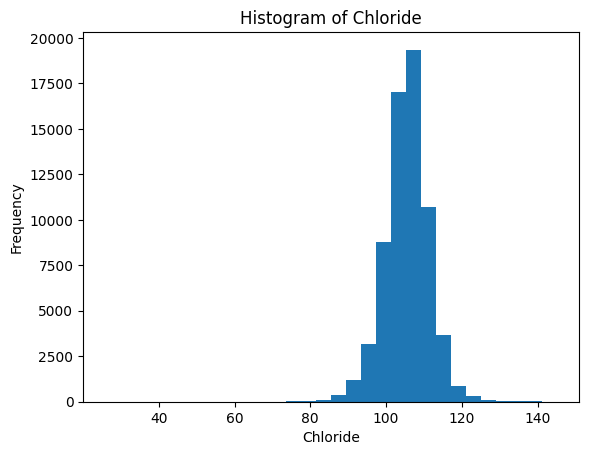

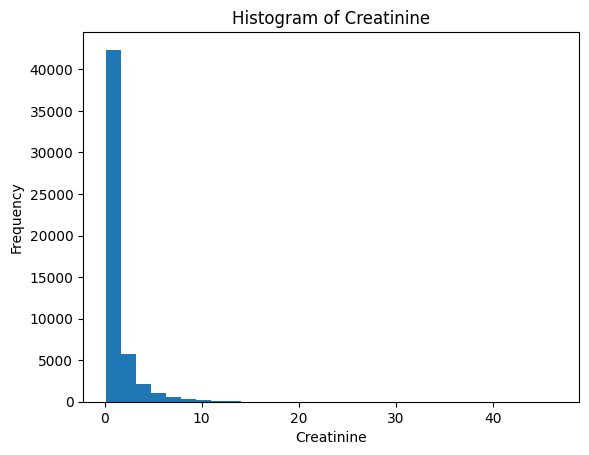

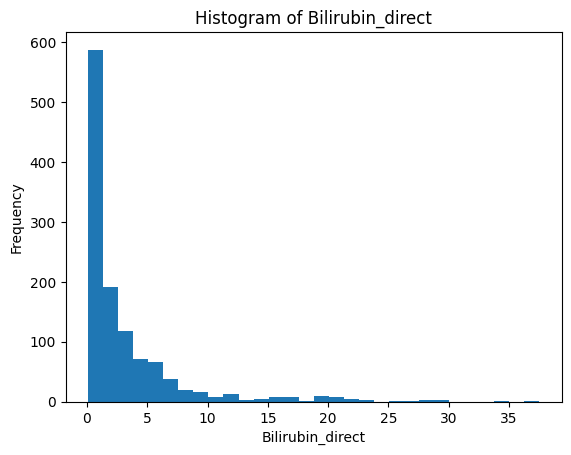

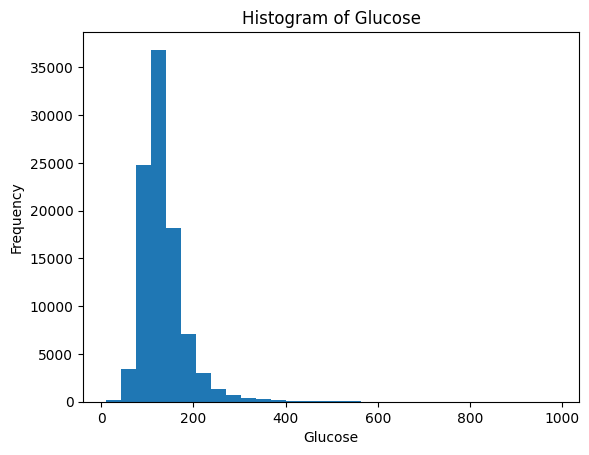

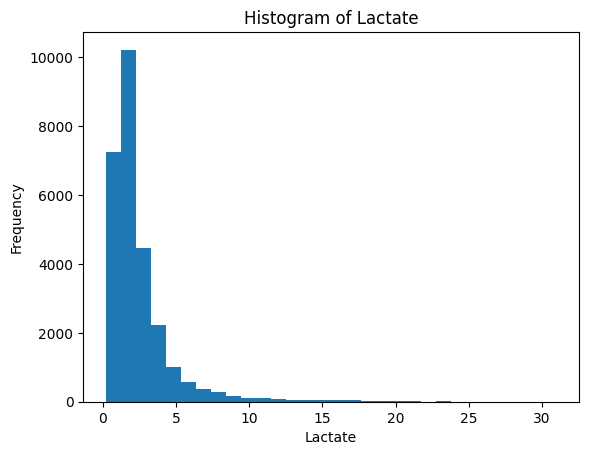

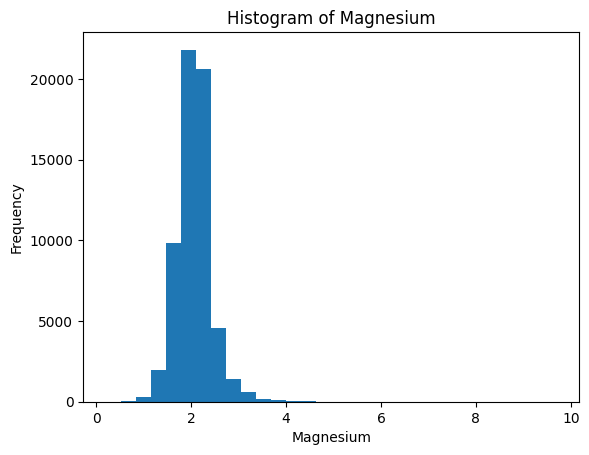

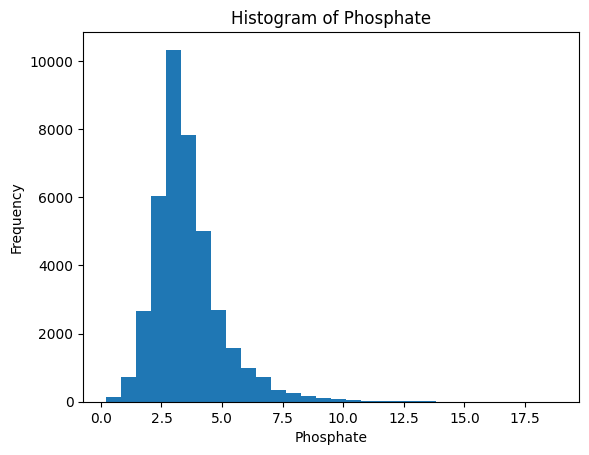

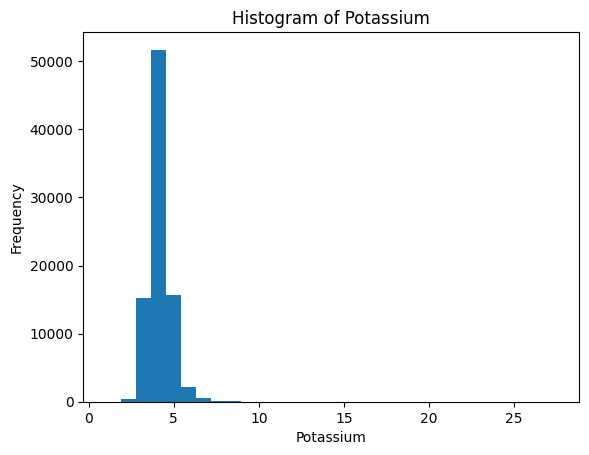

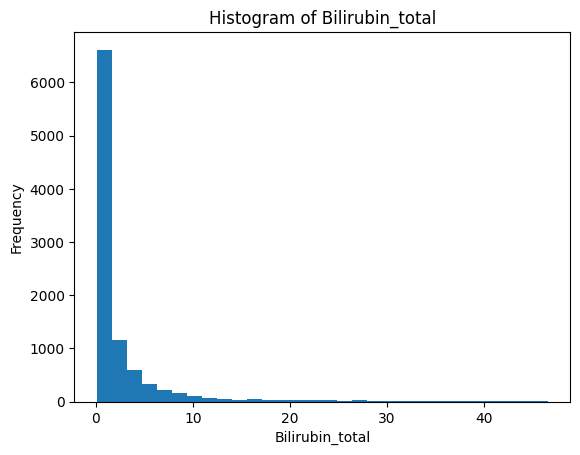

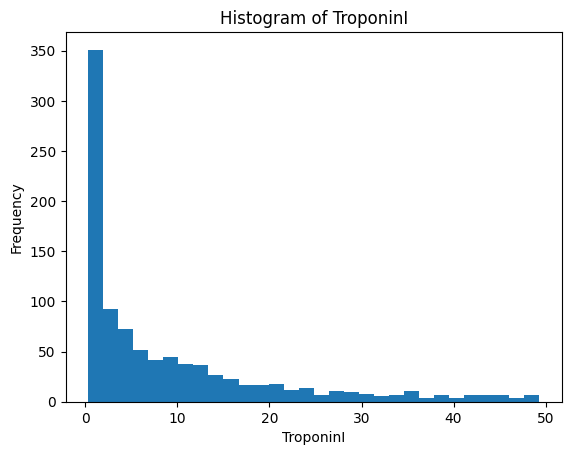

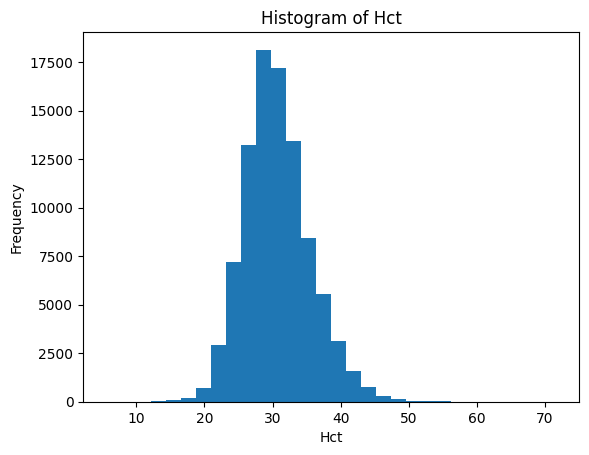

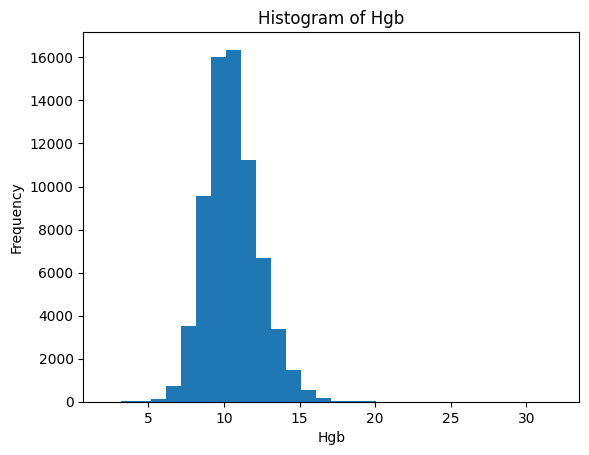

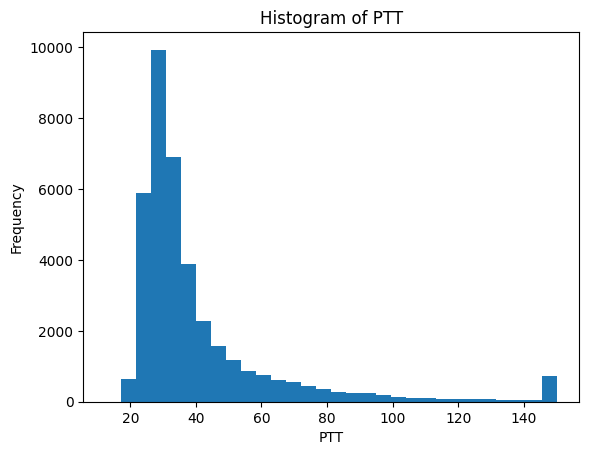

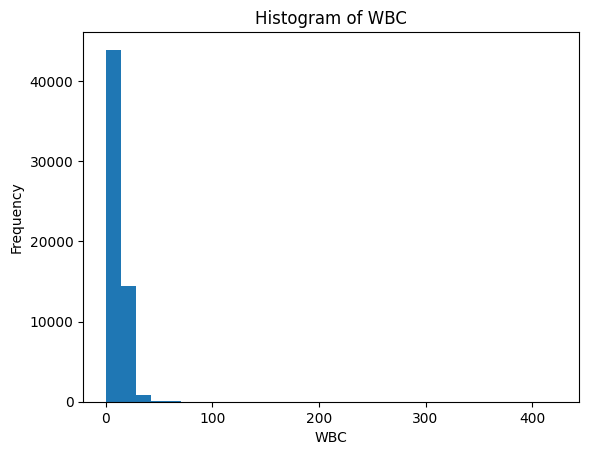

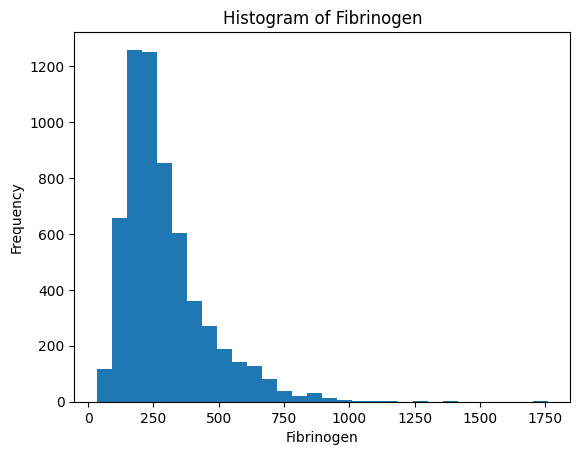

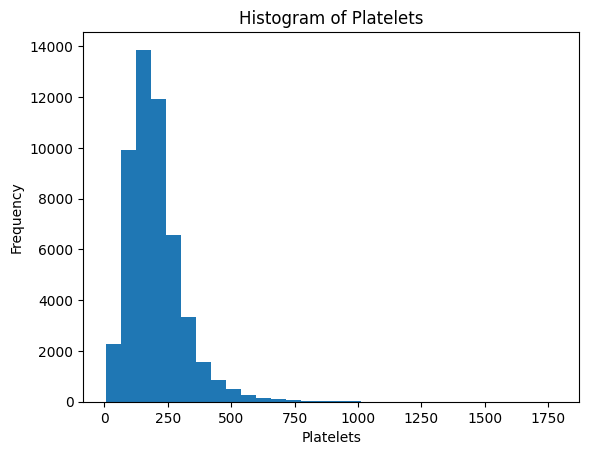

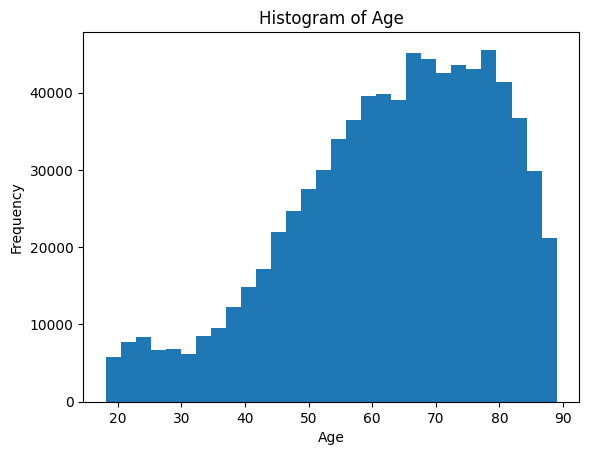

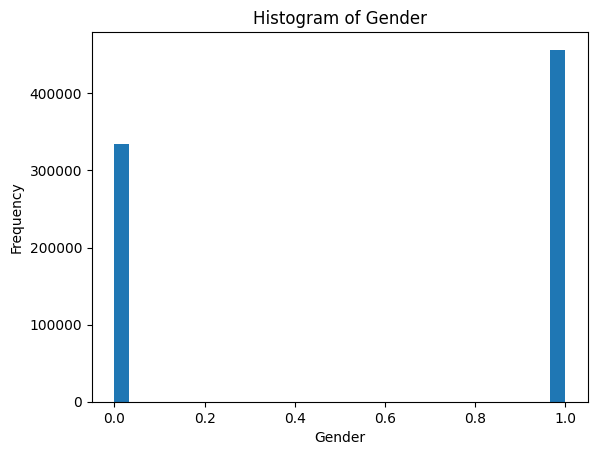

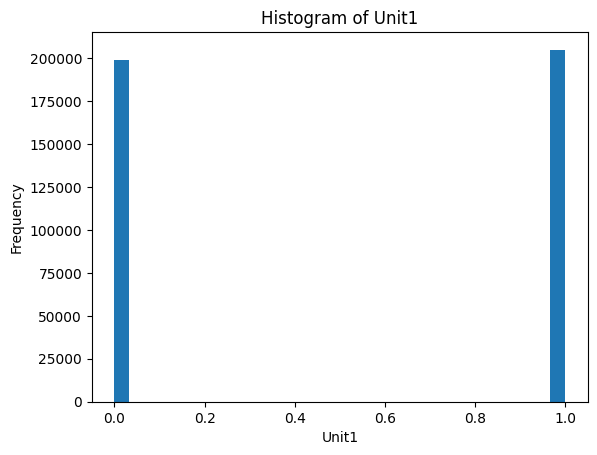

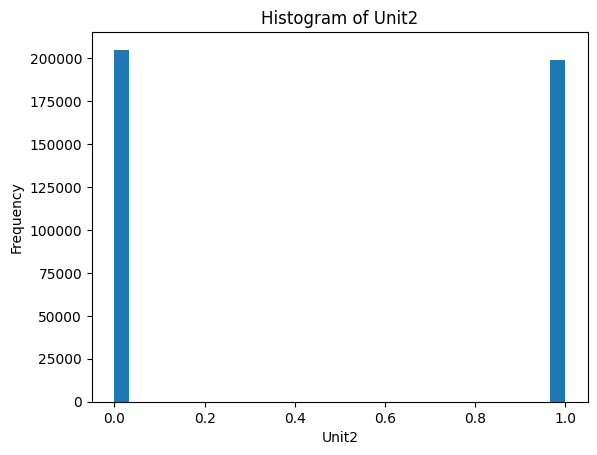

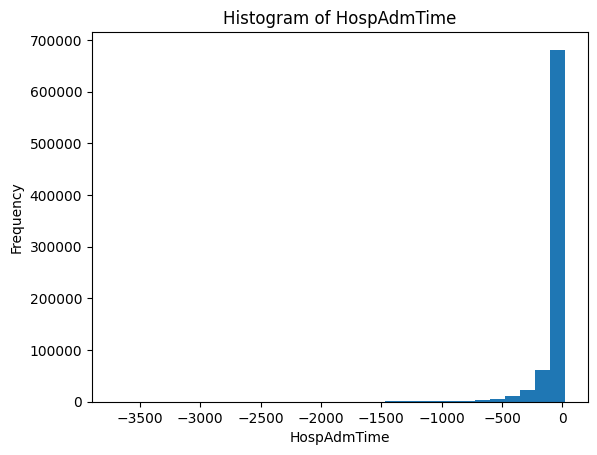

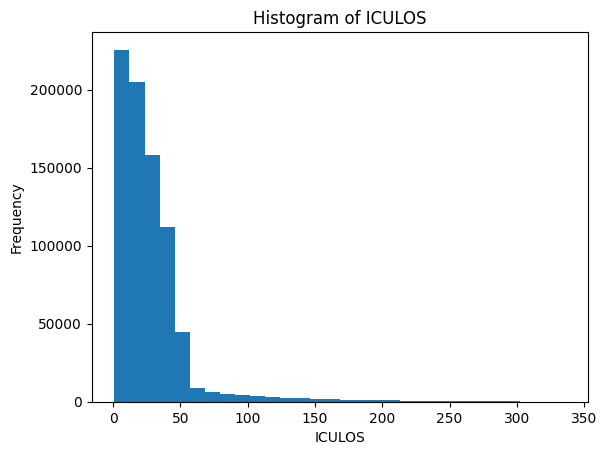

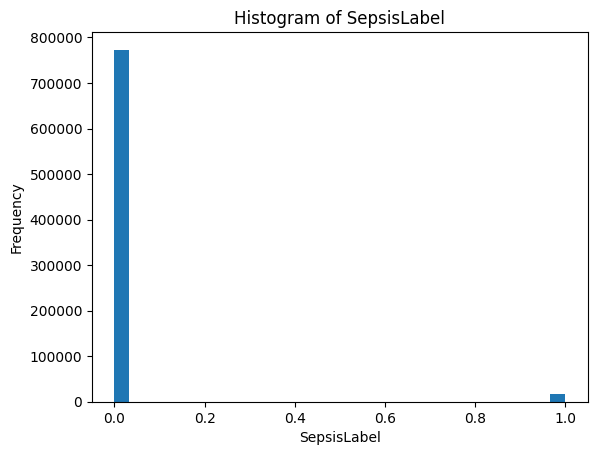

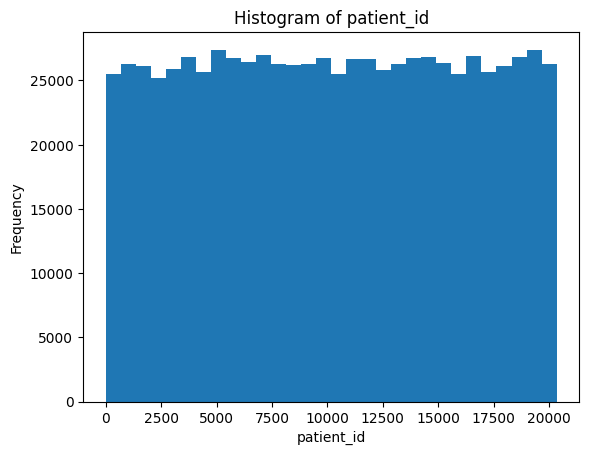

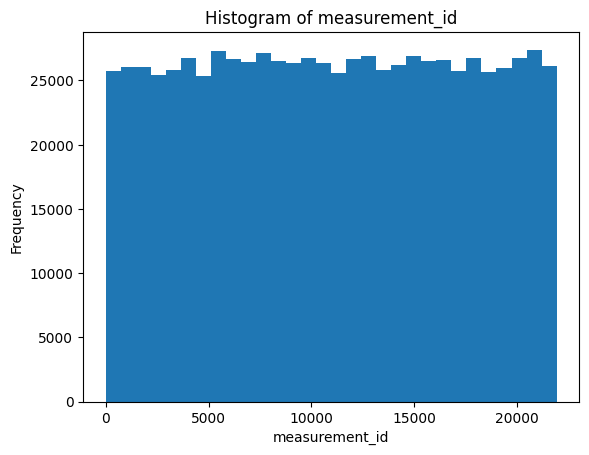

In [ ]:
# Plot all num columns distribution
for column in full_df.columns:
    # Generate histogram for the current column
    plt.figure()  # Create a new figure for each column
    full_df[column].plot(kind='hist', bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()  # Display the histogram

## Initial Interpolation

In [31]:
# interpolate full df with different boundaries (1, 3, 5 missing values)
interpolation_limits = [1, 3, 5]

full_df_interpolated = [full_df.interpolate(limit=lim) for lim in interpolation_limits]

In [32]:
# interpolate full df with different boundaries (1, 3, 5 missing values)
#interpolation_limits = [1, 3, 5]

#full_df_interpolated = [pd.concat([d.interpolate(limit=lim) for d in full_df_from_disk]) for lim in interpolation_limits]

In [73]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

We see that the columns `Age, ICULOS, HospAdmTime, Gender` and `SepsisLabel` are thankfully complete. No need to interpolate those, dropping those for further analysis. `EtCO2` is dropped for missing data entirely.

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

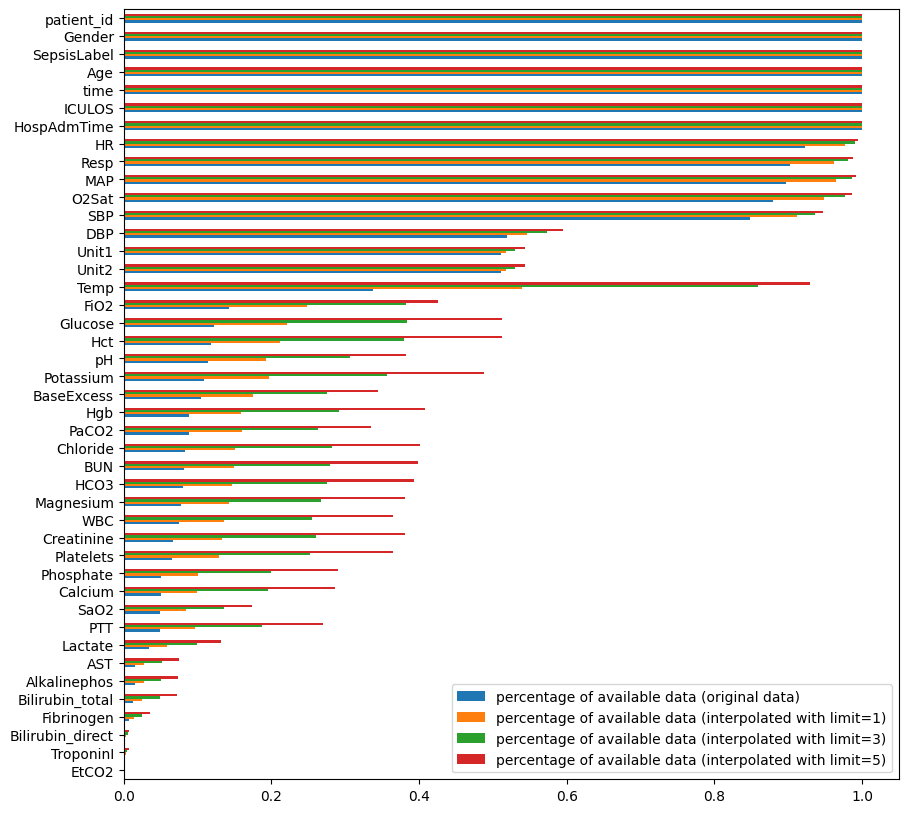

In [34]:
# recalculate with the smaller data frame.
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

fig, ax = plt.subplots()

value_availability_interpolated = [
    d.count().sort_values()/full_df.shape[0] for d in full_df_interpolated
]

res = pd.concat([value_availability, *value_availability_interpolated],axis=1)

res.plot.barh(figsize=(10,10), ax=ax)
ax.legend(["percentage of available data (original data)",
           *[f"percentage of available data (interpolated with limit={lim})" for lim in interpolation_limits]])

## Analyse Feature Contribution

Analyse which features are related to the different states of sepsis (no sepsis vs. sepsis).

In [63]:
ref_df =full_df_interpolated[2]
ref_df_cpy = red_df.copy()
display(ref_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,NaN,134.0,72.67,NaN,20.0,NaN,NaN,...,NaN,266.000000,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,56.0,98.5,NaN,143.0,80.33,NaN,18.0,NaN,NaN,...,NaN,266.333333,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.220000,154.0,83.33,NaN,16.0,NaN,NaN,...,NaN,266.666667,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.406667,155.0,98.33,NaN,20.0,NaN,NaN,...,NaN,267.000000,76.16,0,1.0,0.0,-0.02,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,34,112.0,93.5,37.055000,93.0,61.00,57.0,22.0,NaN,-1.0,...,NaN,NaN,76.78,0,NaN,NaN,-112.33,35,0,20335
790211,35,105.0,97.0,37.137500,89.0,64.00,52.0,20.0,NaN,NaN,...,NaN,NaN,76.78,0,NaN,NaN,-112.33,36,0,20335
790212,36,107.0,98.0,37.220000,91.0,54.50,61.0,27.0,NaN,NaN,...,NaN,NaN,76.78,0,NaN,NaN,-112.33,37,0,20335
790213,37,109.0,98.0,37.220000,86.0,72.00,58.0,16.0,NaN,NaN,...,NaN,NaN,76.78,0,NaN,NaN,-112.33,38,0,20335


### Using KNNs

In [36]:
print("std dev:")
#display(ref_df.std().sort_values(ascending=False))

ref_availability = ref_df.count().sort_values(ascending=False)/ref_df.shape[0]

print("availability")
display(ref_availability)

std dev:
availability


time                1.000000
Age                 1.000000
SepsisLabel         1.000000
ICULOS              1.000000
Gender              1.000000
patient_id          1.000000
HospAdmTime         0.999996
HR                  0.994181
MAP                 0.991803
Resp                0.987288
O2Sat               0.986154
SBP                 0.946901
Temp                0.930277
DBP                 0.594604
Unit2               0.543175
Unit1               0.543175
Hct                 0.512568
Glucose             0.512424
Potassium           0.487977
FiO2                0.425950
Hgb                 0.407562
Chloride            0.401179
BUN                 0.399070
HCO3                0.393194
pH                  0.382641
Magnesium           0.380451
Creatinine          0.380346
WBC                 0.365255
Platelets           0.364916
BaseExcess          0.343734
PaCO2               0.334175
Phosphate           0.290766
Calcium             0.286647
PTT                 0.269301
SaO2          

In [38]:
import math
def classify_pairs(df):
  """Take pairs of time series values and assign a sepsis_class as follows:
  00: A
  01: B
  10: C
  11: D

  Ensures that no comparisons are done between patients.
  """
  sepsis_label_df = df.diff()["SepsisLabel"].replace({1: "B", -1: "C"})
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 0)["SepsisLabel"])] = "A"
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 1)["SepsisLabel"])] = "D"
  sepsis_label_df[df.diff()["patient_id"] != 0] = math.nan

  _df = df.copy()
  _df["SepsisClass"] = sepsis_label_df
  return _df

In [39]:
print("distribution of transitions: A remains non-septic, B becomes septic, D remains septic")
sepsis_class_df = classify_pairs(ref_df)
display(sepsis_class_df["SepsisClass"].value_counts())
print("sanity check: overall (non-)septic timestamps")
display(ref_df["SepsisLabel"].value_counts())

distribution of transitions: A remains non-septic, B becomes septic, D remains septic


A    752946
D     15346
B      1587
Name: SepsisClass, dtype: int64

sanity check: overall (non-)septic timestamps


0    773079
1     17136
Name: SepsisLabel, dtype: int64

In [40]:
import xgboost as xgb

# try random forest as outlined here: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# one hot encoding is skipped (we only have binary or continous data, nothing categorical)
# we also don't have temporal variables

# we can try the following data sets:
# original data (classified as sepsis/non-sepsis)
# original data (classified as transitions)
# pairs of data (classified as transitions)

# todo: should data be normalized, like pixels (to [0, 1]?)
labels = np.array(ref_df['SepsisLabel'])
ref_df_nosepsis = ref_df.drop('SepsisLabel', axis = 1)
ref_df_names = list(ref_df_nosepsis.columns)
ref_df_as_array = np.array(ref_df_nosepsis)


# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(ref_df_as_array, labels, test_size = 0.25, random_state = 42)

### sklearn trees (hist gradient boosting)

In [41]:
# Import the model we are using
# Random Forest does not work due to NaN values.
# HistGradientBoostingClassifier is suggested as alternative but that one does
#  not give importances.
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier # Instantiate model with 1000 decision trees
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42) # Train the model on training data
rf = HistGradientBoostingClassifier(verbose=1, max_depth=12, max_iter=500, random_state = 42)
est = rf.fit(train_features, train_labels);

Binning 0.179 GB of training data: 1.325 s
Binning 0.020 GB of validation data: 0.073 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.09850, val loss: 0.09932, in 0.122s
[2/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.09590, val loss: 0.09708, in 0.130s
[3/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.09405, val loss: 0.09542, in 0.135s
[4/500] 1 tree, 31 leaves, max depth = 11, train loss: 0.09254, val loss: 0.09419, in 0.142s
[5/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.09130, val loss: 0.09311, in 0.143s
[6/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.09021, val loss: 0.09225, in 0.162s
[7/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.08934, val loss: 0.09147, in 0.147s
[8/500] 1 tree, 31 leaves, max depth = 12, train loss: 0.08848, val loss: 0.09081, in 0.152s
[9/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.08781, val loss: 0.09029, in 0.160s
[10/500] 1 tree, 31 leaves, max depth = 11, train

In [42]:
# use a confusion matrix here to get a better idea of how good we are:
# https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

print(f"test data accuracy: {est.score(train_features, train_labels)}")
print(f"validation data accuracy: {est.score(test_features, test_labels)}")

test data accuracy: 0.9859970539650829
validation data accuracy: 0.9812304483837331


In [43]:
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
np.set_printoptions(suppress=True)

preds = est.predict(test_features)


# pos_label=1 (the default) is correct for us.
print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(f"recall: {recall_score(test_labels, preds)}")
print(f"balanced accuracy: {balanced_accuracy_score(test_labels, preds)}")
print(f"f1 score: {f1_score(test_labels, preds)}")
print(f"confusion matrix (non-normalized):\n {confusion_matrix(test_labels, preds, normalize=None)}")
print(f"confusion matrix (normalized over true classes/rows):\n {confusion_matrix(test_labels, preds, normalize='true')}")

print(classification_report(test_labels, preds, target_names=["no sepsis", "sepsis"]))

accuracy: 0.9812304483837331
recall: 0.16731875719217493
balanced accuracy: 0.5834264701911995
f1 score: 0.2816737698566447
confusion matrix (non-normalized):
 [[193119     90]
 [  3618    727]]
confusion matrix (normalized over true classes/rows):
 [[0.99953418 0.00046582]
 [0.83268124 0.16731876]]
              precision    recall  f1-score   support

   no sepsis       0.98      1.00      0.99    193209
      sepsis       0.89      0.17      0.28      4345

    accuracy                           0.98    197554
   macro avg       0.94      0.58      0.64    197554
weighted avg       0.98      0.98      0.97    197554



In [44]:
def prepare_for_forest(df):

  assert('SepsisLabel' in df)
  labels = np.array(df['SepsisLabel'])
  df = df.drop('SepsisLabel', axis = 1)
  df_names = list(df.columns)
  df_as_array = np.array(df)

  return labels, df, df_names, df_as_array

In [45]:
import math
# make our own test data (last 10% of patients)
test_df = ref_df_cpy.tail(math.floor(0.1*len(ref_df_cpy)))
# test_df["SepsisPrediction"] = preds

labels, test_df, test_df_names, test_df_as_array = prepare_for_forest(ref_df_cpy)

print(len(labels))
print(len(test_labels))
print(len(preds))

preds = est.predict(test_df_as_array)
display(preds)

NameError: ignored

In [46]:
# runtime:
# model iterations | time
# 10               | 2:26
# 20               | 4:08
# 30               | 6 min (?)
# 40               | 7:54
# 100              | 17:19
# 700              | 1:51:34
# As this has complexity in O(n^2), where n is the number of model parameters
# (roughly 50 in our case), we expect this value to decrease a lot after parameter
# elimination


# see here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance


train_result = permutation_importance(
    rf, train_features, train_labels, n_repeats=3, random_state=42, n_jobs=-1
)
test_results = permutation_importance(
    rf, test_features, test_labels, n_repeats=3, random_state=42, n_jobs=-1
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=ref_df.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=ref_df.columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

KeyboardInterrupt: ignored

In [ ]:
# Display Learning Curve (long runtime)

from sklearn.model_selection import LearningCurveDisplay
# LearningCurveDisplay.from_estimator(est, train_features, train_labels, n_jobs=-1)

### XGBoost

In [47]:
# prepare

# prepare data for use with XGBoost.
# from https://www.datacamp.com/tutorial/xgboost-in-python
dtrain_clf = xgb.DMatrix(train_features, train_labels, feature_names=ref_df_names, enable_categorical=True)
dtest_clf = xgb.DMatrix(test_features, test_labels, feature_names=ref_df_names, enable_categorical=True)

# train
# to convert the SepsisClass (which is not used yet) you have to use a numerical
# representation, where the following snippet might come in handy:
# Encode y to numeric
# y_encoded = OrdinalEncoder().fit_transform(y)
# binary:logistic will give output _probabilites_
params = {"objective": "binary:hinge", "tree_method": "gpu_hist"}

n = 1000
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50 # Activate early stopping
)

# evaluate
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_clf)

[0]	train-error:0.97842	validation-error:0.97801
[10]	train-error:0.02112	validation-error:0.02175
[20]	train-error:0.02073	validation-error:0.02150
[30]	train-error:0.02029	validation-error:0.02129
[40]	train-error:0.01984	validation-error:0.02104
[50]	train-error:0.01940	validation-error:0.02081
[60]	train-error:0.01883	validation-error:0.02055
[70]	train-error:0.01829	validation-error:0.02026
[80]	train-error:0.01783	validation-error:0.01994
[90]	train-error:0.01743	validation-error:0.01967
[100]	train-error:0.01700	validation-error:0.01949
[110]	train-error:0.01666	validation-error:0.01925
[120]	train-error:0.01641	validation-error:0.01902
[130]	train-error:0.01618	validation-error:0.01891
[140]	train-error:0.01590	validation-error:0.01868
[150]	train-error:0.01569	validation-error:0.01863
[160]	train-error:0.01548	validation-error:0.01844
[170]	train-error:0.01519	validation-error:0.01827
[180]	train-error:0.01493	validation-error:0.01809
[190]	train-error:0.01463	validation-error

In [48]:
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
np.set_printoptions(suppress=True)

# pos_label=1 (the default) is correct for us.
print(f"accuracy: {accuracy_score(test_labels, preds)}")
print(f"recall: {recall_score(test_labels, preds)}")
print(f"balanced accuracy: {balanced_accuracy_score(test_labels, preds)}")
print(f"f1 score: {f1_score(test_labels, preds)}")
print(f"confusion matrix (non-normalized):\n {confusion_matrix(test_labels, preds, normalize=None)}")
print(f"confusion matrix (normalized over true classes/rows):\n {confusion_matrix(test_labels, preds, normalize='true')}")

print(classification_report(test_labels, preds, target_names=["no sepsis", "sepsis"]))

accuracy: 0.9834880589610941
recall: 0.30678941311852703
balanced accuracy: 0.652747738767908
f1 score: 0.4497300944669365
confusion matrix (non-normalized):
 [[192959    250]
 [  3012   1333]]
confusion matrix (normalized over true classes/rows):
 [[0.99870606 0.00129394]
 [0.69321059 0.30678941]]
              precision    recall  f1-score   support

   no sepsis       0.98      1.00      0.99    193209
      sepsis       0.84      0.31      0.45      4345

    accuracy                           0.98    197554
   macro avg       0.91      0.65      0.72    197554
weighted avg       0.98      0.98      0.98    197554



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

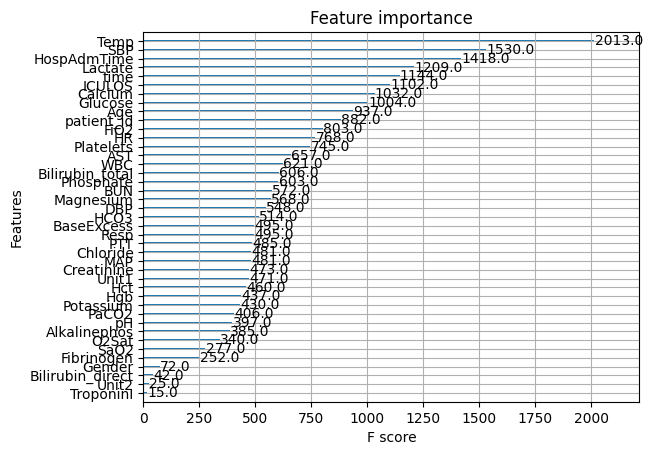

In [49]:
from xgboost import plot_importance
plot_importance(model)

In [50]:
# now using cross-validation

results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20,
)
display(results.tail())

,train-error-mean,train-error-std,test-error-mean,test-error-std
300,0.012621,0.000522,0.018135,0.000491
301,0.012611,0.000539,0.018122,0.000497
302,0.012600,0.000539,0.018112,0.000506
303,0.012598,0.000541,0.018112,0.000516
304,0.012584,0.000543,0.018090,0.000479


In [ ]:
# Ideen:

# Zahlen skalieren (auf 0..1)
# Klassen balancieren
# Vorhersagezeit als neue Metrik
# Zeitfenster erhöhen (bisher nur Messung für Messung)
# ICULOS aus den Variablen raus?
# Wie *Früh*erkennung?

In [ ]:
# Reimplement CaptureStatistics from "a study of kNN using ICU multivariate data"

# 1) z-score normalization
# 2) find min, max, mean, moving average for each (multivariate) time series
# 3) find min, max, mean, moving average for Q (the time series that should be classified).
# 4) find k nearest neighbors using kNN
# 5) apply majority vote, classify Q.

## Filtering and Interpolation

Following the analysis of feature contribution and the initial interpolation of missing values, we will select the most important features to predict sepsis. Also, since the LSTM requires a data set without missing value, we will impute all remaining missing values.

In [51]:
from sklearn.feature_selection import SelectFromModel

For prediction, we will use all features except the 10 least important features.

In [75]:
# Get n most important features
feature_names = model.feature_names

# Get the feature importance dictionary
feature_importance = model.get_score(importance_type="gain")

# Sort the feature importance in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get the top N most important features
top_n_features = sorted_feature_importance[:-10]  # N=-10; Replace with the desired number of features
to_drop_features = sorted_feature_importance[-10:]

# Get the actual feature names of the top features
top_feature_names = [feature for feature, _ in top_n_features]
to_drop_feature_names = [feature for feature, _ in to_drop_features]

In [76]:
# Features that will be kept
top_feature_names

['ICULOS',
 'Lactate',
 'Unit2',
 'HospAdmTime',
 'SBP',
 'Temp',
 'FiO2',
 'Unit1',
 'time',
 'Glucose',
 'Resp',
 'Age',
 'MAP',
 'AST',
 'Calcium',
 'Bilirubin_total',
 'Alkalinephos',
 'Platelets',
 'O2Sat',
 'Magnesium',
 'patient_id',
 'Fibrinogen',
 'Phosphate',
 'WBC',
 'BUN',
 'HR',
 'Hgb',
 'HCO3',
 'Gender',
 'DBP',
 'Creatinine']

In [77]:
# Features that will be droped
to_drop_feature_names

['Potassium',
 'Hct',
 'Chloride',
 'PaCO2',
 'PTT',
 'pH',
 'BaseExcess',
 'SaO2',
 'Bilirubin_direct',
 'TroponinI']

In [78]:
# Select subsample of data frame
red_df = ref_df.drop(to_drop_feature_names, axis=1)


In [79]:
red_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,HCO3,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,NaN,134.0,72.67,NaN,20.0,NaN,NaN,...,NaN,266.000000,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,56.0,98.5,NaN,143.0,80.33,NaN,18.0,NaN,NaN,...,NaN,266.333333,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.220000,154.0,83.33,NaN,16.0,NaN,NaN,...,NaN,266.666667,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.406667,155.0,98.33,NaN,20.0,NaN,NaN,...,NaN,267.000000,76.16,0,1.0,0.0,-0.02,5,0,0


In [80]:
# Display amount of remaining missing values
value_availability = red_df.count().sort_values()/red_df.shape[0]
display(value_availability)

EtCO2              0.000000
Fibrinogen         0.034947
Bilirubin_total    0.071548
Alkalinephos       0.073118
AST                0.075078
Lactate            0.132249
Calcium            0.286647
Phosphate          0.290766
Platelets          0.364916
WBC                0.365255
Creatinine         0.380346
Magnesium          0.380451
HCO3               0.393194
BUN                0.399070
Hgb                0.407562
FiO2               0.425950
Glucose            0.512424
Unit2              0.543175
Unit1              0.543175
DBP                0.594604
Temp               0.930277
SBP                0.946901
O2Sat              0.986154
Resp               0.987288
MAP                0.991803
HR                 0.994181
HospAdmTime        0.999996
ICULOS             1.000000
time               1.000000
Age                1.000000
SepsisLabel        1.000000
Gender             1.000000
patient_id         1.000000
dtype: float64

Several columns still have a massiv amount of missing data, i.e. less than 10% available data. Susequently, all columns with less than 10% overall data will be dropped.

In [81]:
threshold = 0.90  # Set the threshold for missing data

# Calculate the number of non-null values in each column
non_null_counts = red_df.notnull().sum()

# Calculate the percentage of missing full_df in each column
missing_percentages = 1 - (non_null_counts / len(red_df))

# Identify columns with missing data exceeding the threshold
columns_to_drop = missing_percentages[missing_percentages > threshold].index

# Drop columns with excessive missing data
red_df = red_df.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
print("Dropped columns (less that 10% availble data):", columns_to_drop)

Dropped columns (less that 10% availble data): Index(['EtCO2', 'AST', 'Alkalinephos', 'Bilirubin_total', 'Fibrinogen'], dtype='object')


Interpolate remaining missing data.

In [82]:
# Forward- and backward fill missing values at the start of each patient's data
red_df_filled = red_df.groupby('patient_id', group_keys=False).apply(lambda group: group.ffill())
red_df_filled = red_df_filled.groupby('patient_id', group_keys=False).apply(lambda group: group.bfill())

In [83]:
# Interpolate missing values within each patient's data using linear interpolation
df_int = red_df_filled.groupby('patient_id', group_keys=False).apply(lambda x: x.interpolate(method='linear'))

In [84]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.220000,134.0,72.67,NaN,20.0,24.0,NaN,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.220000,134.0,72.67,NaN,20.0,24.0,NaN,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,56.0,98.5,36.220000,143.0,80.33,NaN,18.0,24.0,NaN,...,14.711111,266.333333,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.220000,154.0,83.33,NaN,16.0,24.0,NaN,...,14.622222,266.666667,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.406667,155.0,98.33,NaN,20.0,24.0,NaN,...,14.533333,267.000000,76.16,0,1.0,0.0,-0.02,5,0,0


For patients with completely missing variables, fill missing values with variable mean over all available patients.

In [85]:
vars = df_int.columns
# Calculate the mean for the variables over all patients
mean_values = df_int[vars].mean()

# Iterate over the variables and fill missing values with the corresponding mean
for variable in vars:
    df_int[variable] = df_int[variable].fillna(mean_values[variable])

In [86]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.220000,134.0,72.67,60.519717,20.0,24.0,0.524644,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.220000,134.0,72.67,60.519717,20.0,24.0,0.524644,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,56.0,98.5,36.220000,143.0,80.33,60.519717,18.0,24.0,0.524644,...,14.711111,266.333333,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.220000,154.0,83.33,60.519717,16.0,24.0,0.524644,...,14.622222,266.666667,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.406667,155.0,98.33,60.519717,20.0,24.0,0.524644,...,14.533333,267.000000,76.16,0,1.0,0.0,-0.02,5,0,0


In [87]:
# Check for remaining missing values
df_int.isnull().values.any()

False

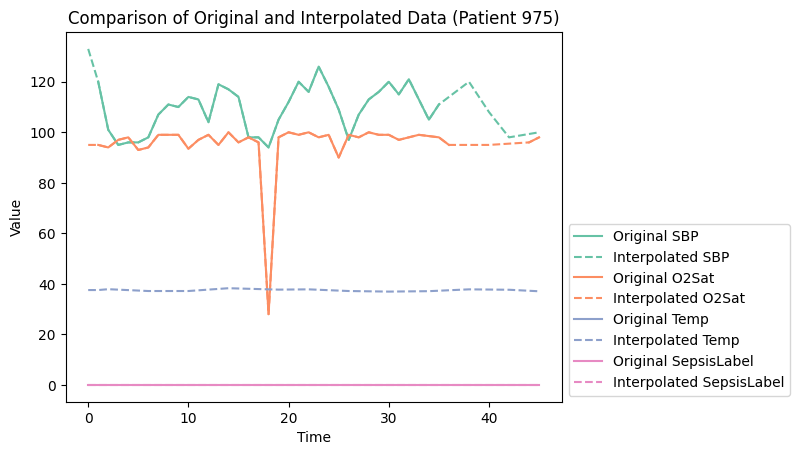

In [88]:
# Example plot of interpolated data
# Choose a specific patient for plotting (e.g., patient_id = 0)
patient_id = 975

# Specify the columns to plot
columns_to_plot = ["SBP", "O2Sat", "Temp", "SepsisLabel"]

# Generate a color palette based on the number of variables
color_palette = sns.color_palette('Set2', len(columns_to_plot))

# Filter the original and interpolated data for the selected patient
original_patient_data = full_df[full_df['patient_id'] == patient_id]
interpolated_patient_data = df_int[df_int['patient_id'] == patient_id]

# Set up the figure and subplot
fig, ax = plt.subplots()

# Iterate over the columns and plot the original and interpolated data
for variable, color in zip(columns_to_plot, color_palette):
    # Plot the original data
    ax.plot(original_patient_data['time'], original_patient_data[variable], label=f'Original {variable}', color=color)

    # Plot the interpolated data
    ax.plot(interpolated_patient_data['time'], interpolated_patient_data[variable], label=f'Interpolated {variable}', linestyle='--', color=color)


# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title(f'Comparison of Original and Interpolated Data (Patient {patient_id})')

# Add legend
ax.legend(bbox_to_anchor=(1, 0.5), loc="upper left")

# Show the plot
plt.show()

## Time Series Prediction Models

### Create test and train set

In [ ]:
# To do: apply to whole sample
n = 80  # Number of patients to select

# Get unique patient IDs
unique_patients = df_int['patient_id'].unique()

# Select a subset of n unique patients
selected_patients = pd.Series(unique_patients).sample(n=n, random_state=2)

# Filter the data frame based on the selected patients and preserve the order
df_int_subs = df_int[df_int['patient_id'].isin(selected_patients)].sort_values(by=['patient_id', 'time'])

#

In [90]:
# unique_patients = df_int_subs['patient_id'].unique()
# print(unique_patients)
# len(unique_patients)

In [95]:
unique_patients = df_int['patient_id'].unique()

# Split the patients into train and test sets
train_patients, test_patients = train_test_split(unique_patients, test_size=0.1, random_state=42)

# Filter the data based on the train and test patients
train_data = df_int[df_int['patient_id'].isin(train_patients)]
test_data = df_int[df_int['patient_id'].isin(test_patients)]

In [97]:
len(unique_patients)

20336

In [93]:
train_data.shape

(710921, 28)

In [94]:
test_data.shape

(79294, 28)

Check for remaining missing data.

In [99]:
train_data.isnull().values.any()

False

In [100]:
test_data.isnull().values.any()

False

Scale the features using MinMaxScaler.

In [101]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

Prepare feature selection.

In [ ]:
features = train_data.loc[:,train_data.columns!="SepsisLabel"].columns

n_features = len(features)-1

In [104]:
train_data.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.220000,134.0,72.67,60.519717,20.0,24.0,0.524644,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.220000,134.0,72.67,60.519717,20.0,24.0,0.524644,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,56.0,98.5,36.220000,143.0,80.33,60.519717,18.0,24.0,0.524644,...,14.711111,266.333333,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.220000,154.0,83.33,60.519717,16.0,24.0,0.524644,...,14.622222,266.666667,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.406667,155.0,98.33,60.519717,20.0,24.0,0.524644,...,14.533333,267.000000,76.16,0,1.0,0.0,-0.02,5,0,0


### LSTM

In [102]:
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

#### Window Size 5

In [105]:
window_size = 5

# Define a function to create sliding windows for each patient
def create_sliding_windows(data):
    """
    Creates sliding windows of a specified size from the given data.

    Args:
        data (pandas.DataFrame): The input data from which sliding windows are created.

    Returns:
        list: A list of sliding windows, where each window is a subset of the input data.

    """
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    return windows

In [106]:
# Create sliding windows for each patient in the training data
train_windows = train_data.groupby('patient_id').apply(create_sliding_windows)

In [108]:
train_data.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.220000,134.0,72.67,60.519717,20.0,24.0,0.524644,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.220000,134.0,72.67,60.519717,20.0,24.0,0.524644,...,14.800000,266.000000,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,56.0,98.5,36.220000,143.0,80.33,60.519717,18.0,24.0,0.524644,...,14.711111,266.333333,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.220000,154.0,83.33,60.519717,16.0,24.0,0.524644,...,14.622222,266.666667,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.406667,155.0,98.33,60.519717,20.0,24.0,0.524644,...,14.533333,267.000000,76.16,0,1.0,0.0,-0.02,5,0,0


In [ ]:
# Prepare training data
train_X = np.empty((0, window_size-1, n_features)) #
train_y = np.empty((0,))
for windows, patient_data in zip(train_windows, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :-1, :n_features]
    y = np.stack(windows)[:, -1, -2]
    train_X = np.concatenate((train_X, X))
    train_y = np.concatenate((train_y, y))

In [ ]:
train_y

In [ ]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y), y=train_y)
class_weights_array

In [ ]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array  ))
class_weights

In [ ]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size-1, n_features)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# Train the model
model.fit(train_X, train_y, epochs=21, batch_size=32, class_weight=class_weights)

In [ ]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [ ]:
# Prepare test data
test_X = np.empty((0, window_size-1, n_features))
test_y_true = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :-1, :n_features]
    y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the second last column
    test_X = np.concatenate((test_X, X))
    test_y_true = np.concatenate((test_y_true, y_true))

In [ ]:
test_y_true

In [ ]:
sum(test_y_true)/len(test_y_true)

In [ ]:
# Make predictions on the test data
test_y_pred = model.predict(test_X)

# Convert predictions to binary values
test_y_pred = (test_y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(test_y_true, test_y_pred)
precision = precision_score(test_y_true, test_y_pred)
recall = recall_score(test_y_true, test_y_pred)
auc_roc = roc_auc_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC Score:", auc_roc)

In [ ]:
# Compute the predicted probabilities for the positive class
test_y_pred_prob = model.predict(test_X)

# Compute the AUC-ROC score
auc_roc = roc_auc_score(test_y_true, test_y_pred_prob)

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(test_y_true, test_y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Create table for results comparison.

In [ ]:
# Define the window sizes
window_sizes = [5, 10]

In [ ]:
# Initialize the table to store the results
results_table = pd.DataFrame(columns=['Window Size', 'Accuracy', 'Precision', 'Recall', 'AUROC'])

In [ ]:
# Add the results to the table
results_table = results_table.append({
        'Window Size': window_sizes[0],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUROC': auc_roc
    }, ignore_index=True)

#### Window Size 10

In [ ]:
window_size = 10

In [ ]:
# Create sliding windows for each patient in the training data
train_windows_10 = train_data.groupby('patient_id').apply(create_sliding_windows)

In [ ]:
# Prepare training data
train_X_10 = np.empty((0, window_size-1, n_features)) #
train_y_10 = np.empty((0,))
for windows, patient_data in zip(train_windows_10, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    if len(scaled_data) > 10:
        X = np.stack(windows)[:, :-1, :n_features]
        y = np.stack(windows)[:, -1, -2]
        train_X_10 = np.concatenate((train_X_10, X))
        train_y_10 = np.concatenate((train_y_10, y))

In [ ]:
train_y_10

In [ ]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y_10), y=train_y_10)
class_weights_array

In [ ]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array))
class_weights

In [ ]:
# Define the LSTM model architecture
model_10 = Sequential()
model_10.add(LSTM(50, input_shape=(window_size-1, n_features)))
model_10.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model_10.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# Train the model
model_10.fit(train_X_10, train_y_10, epochs=21, batch_size=32, class_weight=class_weights)

In [ ]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [ ]:
# Prepare test data
test_X_10 = np.empty((0, window_size-1, n_features))
test_y_true_10 = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    if len(scaled_data) > 10:
        X = np.stack(windows)[:, :-1, :n_features]
        y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the second last column
        test_X_10 = np.concatenate((test_X_10, X))
        test_y_true_10 = np.concatenate((test_y_true_10, y_true))

In [ ]:
test_y_true_10

In [ ]:
sum(test_y_true_10)/len(test_y_true_10)

In [ ]:
# Make predictions on the test data
test_y_pred_10 = model_10.predict(test_X_10)

# Convert predictions to binary values
test_y_pred_10 = (test_y_pred_10 > 0.5).astype(int)

# Evaluate the model
accuracy_10 = accuracy_score(test_y_true_10, test_y_pred_10)
precision_10 = precision_score(test_y_true_10, test_y_pred_10)
recall_10 = recall_score(test_y_true_10, test_y_pred_10)
auc_roc_10 = roc_auc_score(test_y_true_10, test_y_pred_10)

# Print evaluation metrics
print("Accuracy:", accuracy_10)
print("Precision:", precision_10)
print("Recall:", recall_10)
print("AUC-ROC Score:", auc_roc_10)

In [ ]:
# Compute the predicted probabilities for the positive class
test_y_pred_prob_10 = model_10.predict(test_X_10)

# Compute the AUC-ROC score
auc_roc_10 = roc_auc_score(test_y_true_10, test_y_pred_prob_10)

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(test_y_true_10, test_y_pred_prob_10)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc_10))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# Add the results to the table
results_table = results_table.append({
        'Window Size': window_sizes[1],
        'Accuracy': accuracy_10,
        'Precision': precision_10,
        'Recall': recall_10,
        'AUROC': auc_roc_10
    }, ignore_index=True)

#### Compare Model Results

In [ ]:
# Print the results table
print(results_table)

## Open Questions and To Dos

*   Compare different feature selection sets
*   Predict further than one time step (= hour) into future (n-steps ahead)
*   Apply additional prediction models and compare results


